In [1]:
import bayesnewton
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.spatial.distance import cdist
from bayes_opt import BayesianOptimization
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

import sys, os
sys.path.append('../../Utils')
import model_utils as mutils
%load_ext autoreload
%autoreload 2

/Users/SeanNassimiha/miniforge3/envs/mscjax_dev/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
data =  pd.read_csv('../../../Data/pv_power_df_5day_capacity_scaled.csv', index_col='datetime').drop(columns=['2657', '2828']) #DROPPING FAULTY SYSTEMS
uk_pv = pd.read_csv('../../../Data/system_metadata_location_rounded.csv')
uk_pv['ss_id_string'] = uk_pv['ss_id'].astype('str')

lats = dict(uk_pv.set_index('ss_id')['latitude_noisy'])
longs = dict(uk_pv.set_index('ss_id')['longitude_noisy'])

In [3]:
#DATA VARIABLES
# SYSTEMS_NUM = 400
# TIMESTEPS_NUM = int(len(data) / 5)
# TRAIN_FRAC = 0.9
# TEST_STATIONS = 400


# #DATA VARIABLES
SYSTEMS_NUM = 700
TIMESTEPS_NUM = len(data)
TRAIN_FRAC = 0.9
TEST_STATIONS = 179

In [4]:
#TRAIN
data_multiple = data.iloc[:, :SYSTEMS_NUM][:TIMESTEPS_NUM].reset_index()
capacities = uk_pv[uk_pv.ss_id_string.isin(data_multiple.columns)].set_index('ss_id_string')['kwp'].values * 1000
stacked = mutils.stack_dataframe(data_multiple, lats, longs)
X = np.array(stacked[['epoch', 'longitude', 'latitude']])
Y = np.array(stacked[['PV']])
#Create a space-time grid from X and Y
t, R, Y = bayesnewton.utils.create_spatiotemporal_grid(X, Y)


#TEST
data_unseen = data.iloc[:, SYSTEMS_NUM:SYSTEMS_NUM+TEST_STATIONS][:TIMESTEPS_NUM].reset_index()
capacities_unseen = uk_pv[uk_pv.ss_id_string.isin(data_unseen.columns)].set_index('ss_id_string')['kwp'].values * 1000
stacked_unseen = mutils.stack_dataframe(data_unseen, lats, longs)
X_unseen = np.array(stacked_unseen[['epoch', 'longitude', 'latitude']])
Y_unseen = np.array(stacked_unseen[['PV']])
t, R_unseen, Y_unseen = bayesnewton.utils.create_spatiotemporal_grid(X_unseen, Y_unseen)

del data,uk_pv

In [5]:
R_scaler = StandardScaler().fit(R[0])
R_scaled = np.tile(R_scaler.transform(R[0]), (R.shape[0],1, 1)) #renormalise R and project across time
R_scaled_unseen = np.tile(R_scaler.transform(R_unseen[0]), (R_unseen.shape[0],1, 1)) #renormalise R and project across time


In [6]:
def evaluate_IDW(power, time_factor, neighbours_space, neighbours_time, t_train, R_train, Y_train, t_test, R_test, Y_test, capacities_test, mini_batch = 1024):
    '''
    Function that calculates the IWD prediction for a single helf out system
    power - power of distance metric
    time_factor - factor that governs the weighted sum between time and space dimension
    
    returns:
    - MAE of the predictor (averages over all systems)
    - prediction for that specific location and timestep
    
    '''
    print('beginning IDW')
    
#     print('get space neighbours')
    nbrs_space = NearestNeighbors(n_neighbors=neighbours_space, algorithm='ball_tree').fit(R_train)
    distances_neighbours_space, idx_neighbours_space = nbrs_space.kneighbors(R_test)
    
    nbrs_time = NearestNeighbors(n_neighbors=neighbours_time, algorithm = 'kd_tree', p=1).fit(t_train)
    distances_neighbours_time, idx_neighbours_time = nbrs_time.kneighbors(t_test)
    
    predictions_list = []
    MAE_list = []
    Y_MW = Y_test * capacities_test
    
    for first in range(0, len(distances_neighbours_time), mini_batch):
        distances_neighbours_time_batch = distances_neighbours_time[first:first+mini_batch]
        idx_neighbours_time_batch = idx_neighbours_time[first:first+mini_batch]
        len_batch = len(distances_neighbours_time_batch)
        distances = np.add.outer(distances_neighbours_space.T, distances_neighbours_time_batch.T).swapaxes(0,3)
        weights = (1 / distances)** power
        del distances
        norm_weights = weights / np.sum(weights, axis = (2,3))[:,:, np.newaxis, np.newaxis]
        del weights
        y_neighbours = Y_train[idx_neighbours_time_batch][:,:, idx_neighbours_space].swapaxes(1,2)
        
        prediction = np.sum(norm_weights * y_neighbours, axis = (2,3)) 
        predictions_list.append(prediction)
        del norm_weights

    predictions = np.vstack(predictions_list)
    MAE = (np.nanmean((abs(Y_test - predictions) * capacities_test)))
        
    print('Terminated IDW')
    
    return predictions, MAE



beginning IDW
Terminated IDW


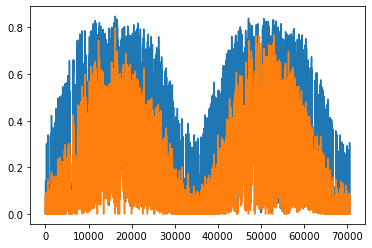

In [7]:
power = 2
time_factor = 1/10
neighbours_space = 20
neighbours_time = 50
predictions, MAE = evaluate_IDW(power, time_factor, neighbours_space, neighbours_time, t, R_scaled[0], Y[:,:,0], t, R_scaled_unseen[0], Y_unseen[:,:,0], capacities_unseen)
plt.plot(predictions[:,10])
plt.plot(Y_unseen[:,10])

In [8]:
def opt_IDW(power, time_factor, n_space, n_time):
    '''
    Wrapper function for bayesian opt of evaluate IDW
    '''
    
    neighbours_space = int(n_space)
    neighbours_time = int(n_time)
    
    predictions, MAE = evaluate_IDW(power, time_factor, neighbours_space, neighbours_time, t, R_scaled[0], Y[:,:,0], t, R_scaled_unseen[0], Y_unseen[:,:,0], capacities_unseen)
    #return the negative value 
    return - MAE



In [9]:
optimiser = BayesianOptimization(
        f = opt_IDW,
        pbounds = {'power' : (0.01, 5), 'time_factor': (0.01, 1), 'n_space': (2, 20), 'n_time': (5, 50)},
        verbose = 2
        )
optimiser.maximize(n_iter = 50, init_points = 6)
print('final result',optimiser.max)

|   iter    |  target   |  n_space  |  n_time   |   power   | time_f... |
-------------------------------------------------------------------------
beginning IDW
Terminated IDW
|  1        | -440.4    |  4.285    |  10.83    |  4.939    |  0.5213   |
beginning IDW
Terminated IDW
|  2        | -442.7    |  3.375    |  22.97    |  4.768    |  0.1571   |
beginning IDW
Terminated IDW
|  3        | -418.0    |  6.398    |  6.579    |  2.383    |  0.4989   |
beginning IDW
Terminated IDW
|  4        | -399.5    |  10.24    |  21.36    |  1.367    |  0.3634   |
beginning IDW
Terminated IDW
|  5        | -400.8    |  12.62    |  27.42    |  0.4768   |  0.1403   |
beginning IDW
Terminated IDW
|  6        | -434.8    |  11.73    |  49.54    |  4.651    |  0.5939   |
beginning IDW
Terminated IDW
|  7        | -416.5    |  4.18     |  33.88    |  0.1453   |  0.2856   |
beginning IDW
Terminated IDW
|  8        | -398.2    |  12.11    |  23.97    |  0.5578   |  0.2862   |
beginning IDW
Terminated IDW

Terminated IDW
|  55       | -407.4    |  20.0     |  23.78    |  0.01     |  0.01     |
beginning IDW
Terminated IDW
|  56       | -402.3    |  20.0     |  9.878    |  0.01     |  1.0      |
final result {'target': -398.15493713989815, 'params': {'n_space': 12.105410668446256, 'n_time': 23.96659623838571, 'power': 0.5578273740300137, 'time_factor': 0.2862407829749734}}


In [10]:
# nbrs_time = NearestNeighbors(n_neighbors=10, algorithm = 'kd_tree', p=1).fit(t)
# distances_neighbours_time, idx_neighbours_time = nbrs_time.kneighbors(t)

# def get_time_neighbours(t, window_size):
#     '''
#     Function that gets the neigbour indices and distances for a vector of 1 increments starting at 0
#     '''
    
#     t_array = np.zeros((len(t)- window_size + 1, window_size))
#     for i in range(len(t) - window_size + 1):
#         t_array[i] = t[i: i + window_size]
#     t_array = t_array.astype('int')

#     idx_array = np.ones(len(t_array)).astype('int')
#     idx_array[0] = int(window_size/2) + 1
#     idx_array[-1] = int(window_size/2) + 1
#     neighbours_idx = np.repeat(t_array, repeats = idx_array, axis=0).astype('int')
#     distances_neighbours = abs(neighbours_idx - t)
    
#     return neighbours_idx, distances_neighbours

# get_time_neighbours(t = t[:,0], window_size = 10)